In [3]:
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import findsources as find
plt.style.use('mplstyle')

In [2]:
from astropy.io import fits
image = 'final_mosaic.fits'  # Change to your file
# image = 'final_mosaicadaptive.fits'  # Change to your file
with fits.open(image) as hdul:
    beam_size = hdul[0].header['BMAJ']* 3600
    print(beam_size)  # Look for BMAJ, BMIN, BPA


40.00000003092


In [4]:
target_ra_hms = '02h00m12s'
target_dec_dms = '-30d53m24s'
search_radius = 20 * 3600 * u.arcsec
flux_thresh = 0.02 # Jy
# Set matching radius (e.g., 45 arcseconds for GLEAM-X resolution)
match_radius = beam_size * u.arcsec 
match_radius = 30 * u.arcsec  # sqrt(40*22)
si = -0.8

# Load GLEAM catalog
gleam_catalog = "GLEAM_EGC_v2.fits.gz"
# gleamx1_catalog = "VIII_110_catalog.dat.gz.fits"
gleamx1_catalog = "VIII_113_catalog2.dat.gz.fits"
tgss_catalog = "TGSSADR1_7sigma_catalog.fits"
tgss_catalog = "J_A+A_598_A78_table3.dat.gz.fits.gz"
pybdsf_catalog= "final_mosaic.pybdsf.srl.fits"
# pybdsf_catalog= "final_mosaicadaptive.pybdsf.srl.fits"
# nvss_catalog= "nvss_catalog.fits"
nvss_catalog= "VIII_65_nvss.dat.gz.fits.gz"


In [5]:
# with fits.open(gleam_catalog) as hdul:
#     print(hdul[1].columns)   # RA in degrees

In [6]:
nu_reference = 147.4
nu_gleam = 151 
nu_gleam_x1 = 151 
# nu_gleam_x1 = 151 
nu_nvss = 1400 
nu_tgss = 150 

fac_gleam = (nu_reference/nu_gleam)**si
print(fac_gleam)

fac_gleam_x1 = (nu_reference/nu_gleam_x1)**si
print(fac_gleam_x1)

fac_nvss = (nu_reference/nu_nvss)**si
print(fac_nvss)

fac_tgss = (nu_reference/nu_tgss)**si
print(fac_tgss)

1.019491410356563
1.019491410356563
6.054864682394719
1.0140865448451666


In [7]:
def matched_sources(gleam_catalog, pybdsf_catalog, flux_thresh, target_ra_hms, target_dec_dms, search_radius, match_radius, names):
    
    gleam_ra, gleam_dec, gleam_flux, gleam_flux_err = find.find_sources(gleam_catalog, flux_thresh, target_ra_hms, target_dec_dms, search_radius, names[0])
    pybdsf_ra, pybdsf_dec, pybdsf_flux, pybdsf_flux_err = find.find_sources(pybdsf_catalog, flux_thresh, target_ra_hms, target_dec_dms, search_radius, names[1])
    
    
    # Convert to SkyCoord objects
    pybdsf_coords = SkyCoord(ra=pybdsf_ra * u.deg, dec=pybdsf_dec * u.deg)
    gleam_coords = SkyCoord(ra=gleam_ra * u.deg, dec=gleam_dec * u.deg)
    
    # Find nearest neighbor in GLEAM catalog for each PyBDSF source
    idx_gleam, d2d, _ = pybdsf_coords.match_to_catalog_sky(gleam_coords)
    
    # Set matching radius (e.g., 45 arcseconds for GLEAM-X resolution)
    matched_mask = d2d < match_radius
    
    # Apply mask to get matched indices
    matched_pybdsf = np.where(matched_mask)[0]  # Indices in PyBDSF catalog
    matched_gleam = idx_gleam[matched_mask]      # Nearest neighbor indices in GLEAM catalog
    matched_sep = d2d[matched_mask].to(u.arcsec) # Separation in arcsec
    return pybdsf_ra[matched_pybdsf], pybdsf_dec[matched_pybdsf], gleam_ra[matched_gleam], gleam_dec[matched_gleam], pybdsf_flux[matched_pybdsf], gleam_flux[matched_gleam], pybdsf_flux_err[matched_pybdsf], gleam_flux_err[matched_gleam]

In [8]:
names = ['gleam', 'pybdsf']

pybdsf_ra, pybdsf_dec, gleam_ra, gleam_dec, pybdsf_flux, gleam_flux, pybdsf_flux_err, gleam_flux_err = matched_sources(gleam_catalog, pybdsf_catalog, flux_thresh,
                                                                                                                       target_ra_hms, target_dec_dms,
                                                                                                                       search_radius, match_radius, 
                                                                                                                       names)
gleam_flux *= (fac_gleam)
gleam_flux_err *= (fac_gleam)

In [9]:
names = ['gleamx1', 'pybdsf']

pybdsf_ra_x1, pybdsf_dec_x1, gleamx1_ra, gleamx1_dec, pybdsf_flux_x1, gleamx1_flux, pybdsf_flux_x1_err, gleamx1_flux_err = matched_sources(gleamx1_catalog, pybdsf_catalog, flux_thresh,
                                                                                                                       target_ra_hms, target_dec_dms,
                                                                                                                       search_radius, match_radius, 
                                                                                                                       names)

gleamx1_flux *= (fac_gleam_x1)
gleamx1_flux_err *= (fac_gleam_x1)

In [10]:
names = ['tgss', 'pybdsf']

pybdsf_ra1, pybdsf_dec1, tgss_ra, tgss_dec, pybdsf_flux1, tgss_flux, pybdsf_flux1_err, tgss_flux_err = matched_sources(tgss_catalog, pybdsf_catalog, flux_thresh,
                                                                                                                       target_ra_hms, target_dec_dms,
                                                                                                                       search_radius, match_radius, 
                                                                                                                       names)

tgss_flux *= 1e-3 # converted to Jy
tgss_flux_err *= 1e-3 # converted to Jy

tgss_flux *= fac_tgss # converted to Jy
tgss_flux_err *= fac_tgss # converted to Jy

In [11]:
names = ['nvss', 'pybdsf']
# names = ['tgss', 'pybdsf']

pybdsf_ra2, pybdsf_dec2, nvss_ra, nvss_dec, pybdsf_flux2, nvss_flux, pybdsf_flux2_err, nvss_flux_err = matched_sources(nvss_catalog, pybdsf_catalog, flux_thresh,
                                                                                                                       target_ra_hms, target_dec_dms,
                                                                                                                       search_radius, match_radius, 
                                                                                                                       names)
# nvss_flux *= (fac_nvss*1e-3)
# nvss_flux_err *= (fac_nvss*1e-3)
nvss_flux *= (fac_nvss)
nvss_flux_err *= (fac_nvss)


In [12]:
delta_ra = 3600 * (pybdsf_ra - gleam_ra) * np.cos(np.radians(pybdsf_dec))
delta_dec = 3600 * (pybdsf_dec - gleam_dec)

delta_ra_x1 = 3600 * (pybdsf_ra_x1 - gleamx1_ra) * np.cos(np.radians(pybdsf_dec_x1))
delta_dec_x1 = 3600 * (pybdsf_dec_x1 - gleamx1_dec)


delta_ra1 = 3600 * (pybdsf_ra1 - tgss_ra) * np.cos(np.radians(pybdsf_dec1))
delta_dec1 = 3600 * (pybdsf_dec1 - tgss_dec)

delta_ra2 = 3600 * (pybdsf_ra2 - nvss_ra) * np.cos(np.radians(pybdsf_dec2))
delta_dec2 = 3600 * (pybdsf_dec2 - nvss_dec)


/tmp/ipykernel_1849563/2498548999.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


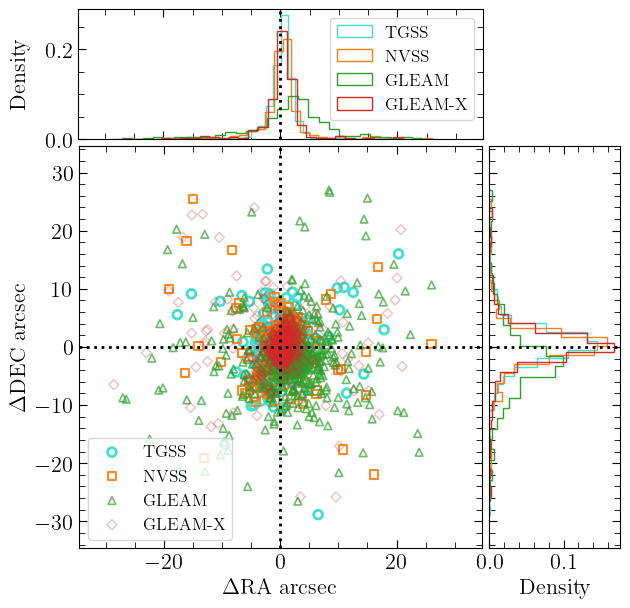

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Compute limits for symmetric axes
max_offset = np.max([
    np.abs(delta_ra).max(), np.abs(delta_dec).max(), 
    np.abs(delta_ra1).max(), np.abs(delta_dec1).max(),
    np.abs(delta_ra2).max(), np.abs(delta_dec2).max(), np.abs(delta_ra_x1).max(), np.abs(delta_dec_x1).max()
])


lim = max_offset * 1.2  # Add 10% margin

# Create figure and subplots
fig = plt.figure(figsize=(7, 7))
grid = plt.GridSpec(4, 4, hspace=0.05, wspace=0.05)  # Reduce spacing

# Scatter plot in the center
main_ax = fig.add_subplot(grid[1:4, 0:3])
# main_ax.scatter(delta_ra1, delta_dec1, color='turquoise', marker='o', label=r'\rm{TGSS}', s=40, alpha=0.7)  # Largest
# main_ax.scatter(delta_ra2, delta_dec2, color='C1', marker='s', label=r'\rm{NVSS}', s=35, alpha=0.7)  # Medium-large
# main_ax.scatter(delta_ra, delta_dec, color='C2', marker='^', label=r'\rm{GLEAM}', s=30, alpha=0.7)  # Medium
# main_ax.scatter(delta_ra_x1, delta_dec_x1, color='C3', marker='D', label=r'\rm{GLEAM-X}', s=25, alpha=0.7)  # Smallest
main_ax.scatter(delta_ra1, delta_dec1, edgecolors='turquoise', facecolors='none', marker='o', label=r'\rm{TGSS}', s=40, linewidth=2)  
main_ax.scatter(delta_ra2, delta_dec2, edgecolors='C1', facecolors='none', marker='s', label=r'\rm{NVSS}', s=35, alpha=0.9, linewidth=1.5)  
main_ax.scatter(delta_ra, delta_dec, edgecolors='C2', facecolors='none', marker='^', label=r'\rm{GLEAM}', s=30, alpha=0.7, linewidth=1.2)  
main_ax.scatter(delta_ra_x1, delta_dec_x1, edgecolors='C3', facecolors='none', marker='D', label=r'\rm{GLEAM-X}', s=25, alpha=0.3, linewidth=1)  


main_ax.axhline(0, color='k', linestyle=':', linewidth=2)
main_ax.axvline(0, color='k', linestyle=':', linewidth=2)
main_ax.set_xlim(-lim, lim)
main_ax.set_ylim(-lim, lim)
main_ax.set_xlabel(r'$\Delta \mathrm{RA}$ \rm{arcsec}')
main_ax.set_ylabel(r'$\Delta \mathrm{DEC}$ \rm{arcsec}')
main_ax.set_aspect('equal')  # Ensure equal aspect ratio
main_ax.legend(fontsize='x-small', frameon=True, loc=3)


# Histogram for RA offsets (top panel)
hist_ra = fig.add_subplot(grid[0, 0:3], sharex=main_ax)
# Histogram for RA offsets (top panel)
hist_ra.hist(delta_ra1, bins=30, color='turquoise', density=True,  histtype='step', linewidth=1, label=r'\rm{TGSS}')
hist_ra.hist(delta_ra2, bins=30, color='C1', histtype='step', density=True, linewidth=1., label=r'\rm{NVSS}')
hist_ra.hist(delta_ra, bins=30, color='C2', histtype='step', density=True, linewidth=1., label=r'\rm{GLEAM}')
hist_ra.hist(delta_ra_x1, bins=30, color='C3', histtype='step', density=True, linewidth=1., label=r'\rm{GLEAM-X}')

# import seaborn as sns
# sns.kdeplot(delta_ra1, color='C0', linestyle='--', linewidth=1.5, ax=hist_ra)
# sns.kdeplot(delta_ra2, color='C1', linestyle='--', linewidth=1.5, ax=hist_ra)
# sns.kdeplot(delta_ra, color='C2', linestyle='--', linewidth=1.5, ax=hist_ra)
# sns.kdeplot(delta_ra_x1, color='C3', linestyle='--', linewidth=1.5, ax=hist_ra)



hist_ra.axvline(0, color='k', linestyle=':', linewidth=2)
hist_ra.set_ylabel(r'\rm{Density}')
plt.setp(hist_ra.get_xticklabels(), visible=False)  # Hide x-labels but keep ticks

hist_ra.legend(fontsize='x-small', frameon=True)

# Histogram for Dec offsets (right panel)
hist_dec = fig.add_subplot(grid[1:4, 3], sharey=main_ax)
hist_dec.hist(delta_dec1, bins=30, orientation='horizontal', color='turquoise', density=True,  histtype='step', linewidth=1)
hist_dec.hist(delta_dec2, bins=30, orientation='horizontal', color='C1', density=True, histtype='step', linewidth=1)
hist_dec.hist(delta_dec, bins=30, orientation='horizontal', color='C2', density=True, histtype='step', linewidth=1)
hist_dec.hist(delta_dec_x1, bins=30, orientation='horizontal', color='C3', density=True, histtype='step', linewidth=1)

hist_dec.axhline(0, color='k', linestyle=':', linewidth=2)
hist_dec.set_xlabel(r'\rm{Density}')
plt.setp(hist_dec.get_yticklabels(), visible=False)  # Hide y-labels but keep ticks

# Legend
# main_ax.legend(fontsize='x-small')

# Align y-labels
fig.align_ylabels([main_ax,hist_ra])
fig.align_xlabels([main_ax,hist_dec])

# Adjust layout and save
# plt.tight_layout(pad=0.5)
# plt.savefig('positional_offsets.pdf', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.savefig('positional_offsets.pdf', bbox_inches='tight', dpi=300)




In [14]:
# from astropy.stats import mad_std
# import numpy as np

# def get_stats(delta_ra, delta_dec):
#     med_ra = np.median(delta_ra)
#     med_dec = np.median(delta_dec)
#     scatter_ra = mad_std(delta_ra)
#     scatter_dec = mad_std(delta_dec)
#     return med_ra, scatter_ra, med_dec, scatter_dec

# # Get stats for each survey
# stats = {
#     "TGSS": get_stats(delta_ra1, delta_dec1),
#     "NVSS": get_stats(delta_ra2, delta_dec2),
#     "GLEAM": get_stats(delta_ra, delta_dec),
#     "GLEAM-X": get_stats(delta_ra_x1, delta_dec_x1),
# }

# # Generate LaTeX table
# print(r"""\begin{table}
# \centering
# \caption{Median positional offsets and scatter (MAD-based) relative to external catalogues.}
# \begin{tabular}{lcc}
# \hline
# Catalogue & $\Delta \mathrm{RA}$ (arcsec) & $\Delta \mathrm{DEC}$ (arcsec) \\
# \hline""")

# for label, (med_ra, mad_ra, med_dec, mad_dec) in stats.items():
#     row = f"{label} & {med_ra:.2f} ± {mad_ra:.2f} & {med_dec:.2f} ± {mad_dec:.2f} \\\\"
#     print(row)

# print(r"""\hline
# \end{tabular}
# \end{table}""")


In [15]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Compute fractional deviation
# fractional_deviation = (pybdsf_flux - gleam_flux) / gleam_flux
# fractional_deviation_x1 = (pybdsf_flux_x1 - gleamx1_flux) / gleamx1_flux
# fractional_deviation1 = (pybdsf_flux1 - tgss_flux) / tgss_flux
# fractional_deviation2 = (pybdsf_flux2 - nvss_flux) / nvss_flux


# # Create figure and subplots
# fig, axs = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [3, 1]}, 
#                         figsize=(6, 7), sharex=True)

# # Compute median flux ratios
# median_ratio_tgss = np.median(pybdsf_flux1 / tgss_flux)
# median_ratio_gleam = np.median(pybdsf_flux / gleam_flux)
# median_ratio_gleamx1 = np.median(pybdsf_flux_x1 / gleamx1_flux)

# # Upper plot: Flux comparison
# axs[0].errorbar(tgss_flux, pybdsf_flux1, xerr=tgss_flux_err, yerr=pybdsf_flux1_err, 
#                 fmt='o', color='turquoise', mec='turquoise', mew=1., ms=3, alpha=1, 
#                 markerfacecolor='none', 
#                 label=fr'\rm{{TGSS, m = {median_ratio_tgss:.2f}}}')

# axs[0].errorbar(gleam_flux, pybdsf_flux, xerr=gleam_flux_err, yerr=pybdsf_flux_err, 
#                 fmt='^', color='C2', mec='C2', mew=1., ms=2, alpha=0.7, 
#                 markerfacecolor='none', 
#                 label=fr'\rm{{GLEAM, m = {median_ratio_gleam:.2f}}}')

# axs[0].errorbar(gleamx1_flux, pybdsf_flux_x1, xerr=gleamx1_flux_err, yerr=pybdsf_flux_x1_err, 
#                 fmt='D', color='C3', mec='C3', mew=1, ms=1, alpha=0.5, 
#                 markerfacecolor='none', 
#                 label=fr'\rm{{GLEAM-X, m = {median_ratio_gleamx1:.2f}}}')

# # Optional NVSS (uncomment if needed)
# # axs[0].errorbar(nvss_flux, pybdsf_flux2, xerr=nvss_flux_err, yerr=pybdsf_flux2_err, 
# #                 fmt='s', color='C1', mec='C1', mew=1.5, ms=5, alpha=0.7, 
# #                 markerfacecolor='none', label=r'\rm{NVSS}')

# # Diagonal equality line
# min_flux = np.amin([np.amin(tgss_flux), np.amin(gleam_flux), np.amin(pybdsf_flux), np.amin(pybdsf_flux1), np.amin(pybdsf_flux2)])
# max_flux = np.amax([np.amax(tgss_flux), np.amax(gleam_flux), np.amax(pybdsf_flux), np.amax(pybdsf_flux1), np.amax(pybdsf_flux2)])
# axs[0].plot([min_flux/1.1, max_flux*1.1], [min_flux/1.1, max_flux*1.1], 'k--', lw=2, zorder=10, label=r'$\rm{Equal\ Flux\ Line}$')

# # Legend with median ratios
# axs[0].legend(loc=2, frameon=True, fontsize='x-small')

# # Labels
# axs[0].set_ylabel(r'$S_{\rm{GMRT}}\ \rm{(Jy)}$')

# # Lower plot: Fractional deviation
# axs[1].errorbar(tgss_flux, fractional_deviation1, xerr=tgss_flux_err, 
#                 yerr=pybdsf_flux1_err/tgss_flux, fmt='o', color='turquoise', 
#                 mec='C1', mew=1, ms=3, alpha=1, markerfacecolor='none')
# axs[1].errorbar(gleam_flux, fractional_deviation, xerr=gleam_flux_err, 
#                 yerr=pybdsf_flux_err/gleam_flux, fmt='^', color='C2', 
#                 mec='C2', mew=1, ms=2, alpha=0.7, markerfacecolor='none')
# axs[1].errorbar(gleamx1_flux, fractional_deviation_x1, xerr=gleamx1_flux_err, 
#                 yerr=pybdsf_flux_x1_err/gleamx1_flux, fmt='D', color='C3', 
#                 mec='C3', mew=1, ms=1, alpha=0.5, markerfacecolor='none')
# # axs[1].errorbar(nvss_flux, fractional_deviation2, xerr=nvss_flux_err, 
# #                 yerr=pybdsf_flux2_err/nvss_flux, fmt='s', color='C1', 
# #                 mec='C1', mew=1.5, ms=5, alpha=0.7, markerfacecolor='none')

# # Reference lines
# axs[1].axhline(0, color='k', linestyle='--', lw=2)
# axs[1].axhline(y=-0.5, ls='--', lw=2, color='gray', alpha=0.7)
# axs[1].axhline(y=0.5, ls='--', lw=2, color='gray', alpha=0.7)

# # Labels
# axs[1].set_xlabel(r'\rm{Flux\ (Jy)}')
# axs[1].set_ylabel(r'$\rm{Fractional\,deviation}$')

# # Log scale
# for ax in axs:
#     ax.set_xscale('log')
# axs[0].set_yscale('log')

# # Aesthetic adjustments
# plt.tight_layout(pad=0.5)
# plt.savefig('flux_comparison.pdf', bbox_inches='tight', dpi=300)


In [16]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Compute fractional deviations
# fractional_deviation = (pybdsf_flux - gleam_flux) / gleam_flux
# fractional_deviation_x1 = (pybdsf_flux_x1 - gleamx1_flux) / gleamx1_flux
# fractional_deviation1 = (pybdsf_flux1 - tgss_flux) / tgss_flux

# # Create figure with 4 subplots
# fig, axs = plt.subplots(nrows=4, ncols=1,
#                         gridspec_kw={'height_ratios': [3, 1, 1, 1]},
#                         figsize=(6, 10), sharex=True)

# # Compute median flux ratios
# median_ratio_tgss = np.median(pybdsf_flux1 / tgss_flux)
# median_ratio_gleam = np.median(pybdsf_flux / gleam_flux)
# median_ratio_gleamx1 = np.median(pybdsf_flux_x1 / gleamx1_flux)

# # --- Top Panel: Flux vs Flux Comparison ---
# axs[0].errorbar(tgss_flux, pybdsf_flux1, xerr=tgss_flux_err, yerr=pybdsf_flux1_err,
#                 fmt='o', color='C0', mec='C0', mew=1., ms=3, alpha=1,
#                 markerfacecolor='none',
#                 label=fr'\rm{{TGSS}}') # , m = {median_ratio_tgss:.2f}

# axs[0].errorbar(gleam_flux, pybdsf_flux, xerr=gleam_flux_err, yerr=pybdsf_flux_err,
#                 fmt='^', color='C2', mec='C2', mew=1., ms=3, alpha=0.9,
#                 markerfacecolor='none',
#                 label=fr'\rm{{GLEAM}}')

# axs[0].errorbar(gleamx1_flux, pybdsf_flux_x1, xerr=gleamx1_flux_err, yerr=pybdsf_flux_x1_err,
#                 fmt='D', color='C3', mec='C3', mew=1, ms=3, alpha=0.8,
#                 markerfacecolor='none',
#                 label=fr'\rm{{GLEAM-X}}')

# # Diagonal equality line
# min_flux = np.amin([np.amin(tgss_flux), np.amin(gleam_flux), np.amin(pybdsf_flux),
#                     np.amin(pybdsf_flux1), np.amin(pybdsf_flux2)])
# max_flux = np.amax([np.amax(tgss_flux), np.amax(gleam_flux), np.amax(pybdsf_flux),
#                     np.amax(pybdsf_flux1), np.amax(pybdsf_flux2)])
# min_flux = 0.02
# axs[0].plot([min_flux/1, max_flux*1.], [min_flux/1, max_flux*1.],
#             'k--', lw=2, zorder=10, label=r'$\rm{Equal\ Flux\ Line}$')

# axs[0].legend(loc=2, frameon=True, fontsize='x-small')
# axs[0].set_ylabel(r'$S_{\rm{GMRT}}\ \rm{(Jy)}$', labelpad=8)
# axs[0].set_yscale('log')

# # --- Panel 2: TGSS fractional deviation ---
# axs[1].errorbar(tgss_flux, fractional_deviation1, xerr=tgss_flux_err,
#                 yerr=pybdsf_flux1_err/tgss_flux, fmt='o', color='C0',
#                 mec='C0', mew=1, ms=3, alpha=1, markerfacecolor='none')
# axs[1].axhline(0, color='k', linestyle='--', lw=2)
# axs[1].axhline(y=-0.5, ls='--', lw=2, color='gray', alpha=0.7)
# axs[1].axhline(y=0.5, ls='--', lw=2, color='gray', alpha=0.7)
# axs[1].set_ylabel(r'\rm{TGSS}', labelpad=8)
# axs[1].text(0.95, 0.9, r'${\rm median}$'+r'$(S_{\rm{GMRT}}/S_{\rm{TGSS}}) = $'+fr' ${median_ratio_tgss:.2f}$',
#             transform=axs[1].transAxes, ha='right', va='top', fontsize='small')

# # --- Panel 3: GLEAM fractional deviation ---
# axs[2].errorbar(gleam_flux, fractional_deviation, xerr=gleam_flux_err,
#                 yerr=pybdsf_flux_err/gleam_flux, fmt='^', color='C2',
#                 mec='C2', mew=1, ms=3, alpha=1, markerfacecolor='none')
# axs[2].axhline(0, color='k', linestyle='--', lw=2)
# axs[2].axhline(y=-0.5, ls='--', lw=2, color='gray', alpha=0.7)
# axs[2].axhline(y=0.5, ls='--', lw=2, color='gray', alpha=0.7)
# axs[2].set_ylabel(r'\rm{GLEAM}', labelpad=8)
# axs[2].text(0.95, 0.9, r'${\rm median}$'+r'$(S_{\rm{GMRT}}/S_{\rm{GLEAM}}) = $'+fr' ${median_ratio_gleam:.2f}$',
#             transform=axs[2].transAxes, ha='right', va='top', fontsize='small')

# # --- Panel 4: GLEAM-X fractional deviation ---
# axs[3].errorbar(gleamx1_flux, fractional_deviation_x1, xerr=gleamx1_flux_err,
#                 yerr=pybdsf_flux_x1_err/gleamx1_flux, fmt='D', color='C3',
#                 mec='C3', mew=1, ms=3, alpha=1, markerfacecolor='none')
# axs[3].axhline(0, color='k', linestyle='--', lw=2)
# axs[3].axhline(y=-0.5, ls='--', lw=2, color='gray', alpha=0.7)
# axs[3].axhline(y=0.5, ls='--', lw=2, color='gray', alpha=0.7)
# axs[3].set_ylabel(r'\rm{GLEAM-X}', labelpad=8)
# axs[3].set_xlabel(r'\rm{Flux\ (Jy)}')
# axs[3].text(0.95, 0.9, r'${\rm median}$'+r'$(S_{\rm{GMRT}}/S_{\rm{GLEAM-X}}) = $'+fr' ${median_ratio_gleamx1:.2f}$',
#             transform=axs[3].transAxes, ha='right', va='top', fontsize='small')

# # Log x-axis for all
# for ax in axs:
#     ax.set_xscale('log')

# # Align y-labels
# fig.align_ylabels(axs)

# # Aesthetic adjustments
# plt.tight_layout(pad=0.5)
# plt.savefig('flux_comparison.pdf', bbox_inches='tight', dpi=300)


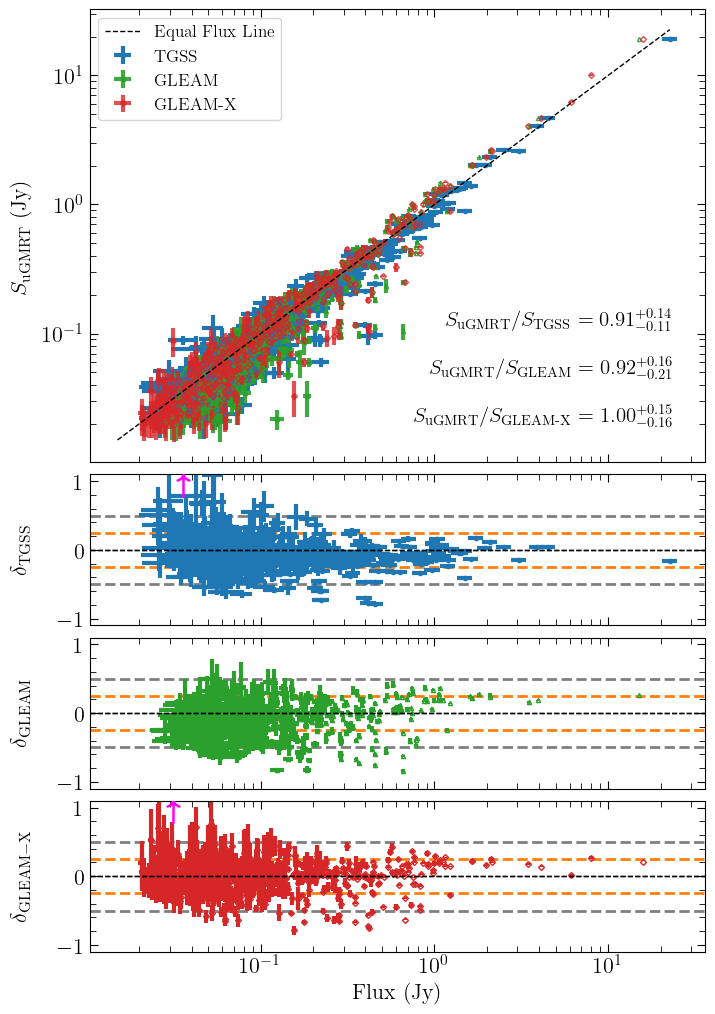

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute fractional deviations ---
fractional_deviation = (pybdsf_flux - gleam_flux) / gleam_flux
fractional_deviation_x1 = (pybdsf_flux_x1 - gleamx1_flux) / gleamx1_flux
fractional_deviation1 = (pybdsf_flux1 - tgss_flux) / tgss_flux

# --- Compute flux ratios and uncertainties ---
def compute_ratio_stats(ratio):
    median = np.median(ratio)
    p25 = np.percentile(ratio, 25)
    p75 = np.percentile(ratio, 75)
    err_plus = p75 - median
    err_minus = median - p25
    return median, err_plus, err_minus

# TGSS
ratio_tgss = pybdsf_flux1 / tgss_flux
median_tgss, errp_tgss, errm_tgss = compute_ratio_stats(ratio_tgss)

# GLEAM
ratio_gleam = pybdsf_flux / gleam_flux
median_gleam, errp_gleam, errm_gleam = compute_ratio_stats(ratio_gleam)

# GLEAM-X
ratio_gleamx1 = pybdsf_flux_x1 / gleamx1_flux
median_gleamx1, errp_gleamx1, errm_gleamx1 = compute_ratio_stats(ratio_gleamx1)

# --- Create figure and subplots ---
fig, axs = plt.subplots(nrows=4, ncols=1,
                        gridspec_kw={'height_ratios': [3., 1, 1, 1]},
                        figsize=(7, 10), sharex=True)

# --- Top Panel: Flux Comparison ---
axs[0].errorbar(tgss_flux, pybdsf_flux1, xerr=tgss_flux_err, yerr=pybdsf_flux1_err,
                fmt='o', color='C0', mec='C0', mew=1., ms=3, alpha=1,
                markerfacecolor='none', label=r'\rm{TGSS}')

axs[0].errorbar(gleam_flux, pybdsf_flux, xerr=gleam_flux_err, yerr=pybdsf_flux_err,
                fmt='^', color='C2', mec='C2', mew=1., ms=3, alpha=0.9,
                markerfacecolor='none', label=r'\rm{GLEAM}')

axs[0].errorbar(gleamx1_flux, pybdsf_flux_x1, xerr=gleamx1_flux_err, yerr=pybdsf_flux_x1_err,
                fmt='D', color='C3', mec='C3', mew=1, ms=3, alpha=0.8,
                markerfacecolor='none', label=r'\rm{GLEAM-X}')

# Diagonal equality line
min_flux = 0.015
max_flux = np.amax([np.amax(tgss_flux), np.amax(gleam_flux), np.amax(pybdsf_flux),
                    np.amax(pybdsf_flux1), np.amax(pybdsf_flux_x1)])
axs[0].plot([min_flux, max_flux], [min_flux, max_flux], 'k--', lw=1, zorder=10,
            label=r'$\rm{Equal\ Flux\ Line}$')

# axs[0].plot([min_flux, max_flux], [2*min_flux, 2*max_flux], 'k--', lw=1, zorder=10,
#             label=r'$\rm{Equal\ Flux\ Line}$')

# axs[0].plot([min_flux, max_flux], [0.5*min_flux, 0.5*max_flux], 'k--', lw=1, zorder=10,
#             label=r'$\rm{Equal\ Flux\ Line}$')


axs[0].legend(loc=2, frameon=True, fontsize='x-small')
axs[0].set_ylabel(r'$S_{\rm{uGMRT}}\ \rm{(Jy)}$', labelpad=8)
axs[0].set_yscale('log')

# Annotate all flux ratios in the top panel
axs[0].text(0.95, 0.08,
            rf'$S_{{\rm{{uGMRT}}}} / S_{{\rm{{TGSS}}}} = {median_tgss:.2f}^{{+{errp_tgss:.2f}}}_{{-{errm_tgss:.2f}}}$' + '\n\n' +
            rf'$S_{{\rm{{uGMRT}}}} / S_{{\rm{{GLEAM}}}} = {median_gleam:.2f}^{{+{errp_gleam:.2f}}}_{{-{errm_gleam:.2f}}}$' + '\n\n' +
            rf'$S_{{\rm{{uGMRT}}}} / S_{{\rm{{GLEAM\mathchar`-X}}}} = {median_gleamx1:.2f}^{{+{errp_gleamx1:.2f}}}_{{-{errm_gleamx1:.2f}}}$',
            transform=axs[0].transAxes, ha='right', va='bottom', fontsize='small',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.75))


# --- Panel 2: TGSS fractional deviation ---
ii = 1
axs[ii].errorbar(tgss_flux, fractional_deviation1, xerr=tgss_flux_err,
                yerr=pybdsf_flux1_err / tgss_flux, fmt='o', color='C0',
                mec='C0', mew=1, ms=3, alpha=1, markerfacecolor='none')

# Handle outliers above ylim
mask_high = fractional_deviation1 > 1.1
if np.any(mask_high):
    axs[ii].scatter(tgss_flux[mask_high], np.ones_like(tgss_flux[mask_high])*0.95,
                   marker=r'$\uparrow$', color='magenta', s=300, label=None, zorder=5)

# Handle outliers below ylim
mask_low = fractional_deviation1 < -1.1
if np.any(mask_low):
    axs[ii].scatter(tgss_flux[mask_low], np.ones_like(tgss_flux[mask_low])*-0.95,
                   marker=r'$\downarrow$', color='magenta', s=200, label=None, zorder=5)

axs[ii].set_ylabel(r'$\delta_{\rm{TGSS}}$', labelpad=8)


# --- Panel 3: GLEAM fractional deviation ---
axs[2].errorbar(gleam_flux, fractional_deviation, xerr=gleam_flux_err,
                yerr=pybdsf_flux_err / gleam_flux, fmt='^', color='C2',
                mec='C2', mew=1, ms=3, alpha=1, markerfacecolor='none')
# Handle outliers above ylim
mask_high = fractional_deviation > 1.1
if np.any(mask_high):
    axs[2].scatter(gleam_flux[mask_high], np.ones_like(gleam_flux[mask_high])*0.95,
                   marker=r'$\uparrow$', color='magenta', s=200, label=None, zorder=5)

# Handle outliers below ylim
mask_low = fractional_deviation < -1.1
if np.any(mask_low):
    axs[2].scatter(gleam_flux[mask_low], np.ones_like(gleam_flux[mask_low])*-0.95,
                   marker=r'$\downarrow$', color='magenta', s=200, label=None, zorder=5)

axs[2].set_ylabel(r'$\delta_{\rm{GLEAM}}$', labelpad=8)



axs[3].errorbar(gleamx1_flux, fractional_deviation_x1, xerr=gleamx1_flux_err,
                yerr=pybdsf_flux_x1_err / gleamx1_flux, fmt='D', color='C3',
                mec='C3', mew=1, ms=3, alpha=1, markerfacecolor='none')

# Handle outliers above ylim
mask_high = fractional_deviation_x1 > 1.1
if np.any(mask_high):
    axs[3].scatter(gleamx1_flux[mask_high], np.ones_like(gleamx1_flux[mask_high])*0.95,
                   marker=r'$\uparrow$', color='magenta', s=300, label=None, zorder=5)

# Handle outliers below ylim
mask_low = fractional_deviation_x1 < -1.1
if np.any(mask_low):
    axs[3].scatter(gleamx1_flux[mask_low], np.ones_like(gleamx1_flux[mask_low])*-0.95,
                   marker=r'$\downarrow$', color='magenta', s=200, label=None, zorder=5)

axs[3].set_ylabel(r'$\delta_{\rm{GLEAM-X}}$', labelpad=8)
axs[3].set_xlabel(r'\rm{Flux\ (Jy)}')

for ii in range(1,4):
    axs[ii].axhline(0, color='k', linestyle='--', lw=1,zorder=10,)

    axs[ii].axhline(y=-0.25, ls='--', lw=2, color='C1',  zorder=1)
    axs[ii].axhline(y=0.25, ls='--', lw=2, color='C1',  zorder=1)
    axs[ii].set_ylim(-1.1, 1.1)

for ii in range(1,4):
    axs[ii].axhline(0, color='k', linestyle='--', lw=1,zorder=10,)

    axs[ii].axhline(y=-0.5, ls='--', lw=2, color='gray', zorder=1)
    axs[ii].axhline(y=0.5, ls='--', lw=2, color='gray',  zorder=1)




# axs[0].set_aspect('equal')   # keeps aspect ratio = 1:1

# --- Apply log x-axis to all panels ---
for ax in axs:
    ax.set_xscale('log')

# --- Align y-labels, finalize plot ---
fig.align_ylabels(axs)
plt.tight_layout(pad=0.1)
plt.savefig('flux_comparison.pdf', bbox_inches='tight', dpi=300)


In [49]:
# import matplotlib.pyplot as plt
# import numpy as np

# # --- Compute fractional deviations ---
# fractional_deviation = (pybdsf_flux - gleam_flux) / gleam_flux
# fractional_deviation_x1 = (pybdsf_flux_x1 - gleamx1_flux) / gleamx1_flux
# fractional_deviation1 = (pybdsf_flux1 - tgss_flux) / tgss_flux

# # --- Compute flux ratios and uncertainties ---
# def compute_ratio_stats(ratio):
#     median = np.median(ratio)
#     p25 = np.percentile(ratio, 25)
#     p75 = np.percentile(ratio, 75)
#     err_plus = p75 - median
#     err_minus = median - p25
#     return median, err_plus, err_minus

# # TGSS
# ratio_tgss = pybdsf_flux1 / tgss_flux
# median_tgss, errp_tgss, errm_tgss = compute_ratio_stats(ratio_tgss)

# # GLEAM
# ratio_gleam = pybdsf_flux / gleam_flux
# median_gleam, errp_gleam, errm_gleam = compute_ratio_stats(ratio_gleam)

# # GLEAM-X
# ratio_gleamx1 = pybdsf_flux_x1 / gleamx1_flux
# median_gleamx1, errp_gleamx1, errm_gleamx1 = compute_ratio_stats(ratio_gleamx1)

# # --- Create figure and subplots ---
# fig, axs = plt.subplots(nrows=4, ncols=1,
#                         gridspec_kw={'height_ratios': [3., 1, 1, 1]},
#                         figsize=(6.5, 10), sharex=True)

# # --- Top Panel: Flux Comparison ---
# axs[0].errorbar(tgss_flux, pybdsf_flux1, xerr=tgss_flux_err, yerr=pybdsf_flux1_err,
#                 fmt='o', color='C0', mec='C0', mew=1., ms=3, alpha=1,
#                 markerfacecolor='none', label=r'\rm{TGSS}')

# axs[0].errorbar(gleam_flux, pybdsf_flux, xerr=gleam_flux_err, yerr=pybdsf_flux_err,
#                 fmt='^', color='C2', mec='C2', mew=1., ms=3, alpha=0.9,
#                 markerfacecolor='none', label=r'\rm{GLEAM}')

# axs[0].errorbar(gleamx1_flux, pybdsf_flux_x1, xerr=gleamx1_flux_err, yerr=pybdsf_flux_x1_err,
#                 fmt='D', color='C3', mec='C3', mew=1, ms=3, alpha=0.8,
#                 markerfacecolor='none', label=r'\rm{GLEAM-X}')

# # Diagonal equality line
# min_flux = 0.02
# max_flux = np.amax([np.amax(tgss_flux), np.amax(gleam_flux), np.amax(pybdsf_flux),
#                     np.amax(pybdsf_flux1), np.amax(pybdsf_flux_x1)])
# axs[0].plot([min_flux, max_flux], [min_flux, max_flux], 'k--', lw=1, zorder=10,
#             label=r'$\rm{Equal\ Flux\ Line}$')




# axs[0].legend(loc=2, frameon=True, fontsize='x-small')
# axs[0].set_ylabel(r'$S_{\rm{uGMRT}}\ \rm{(Jy)}$', labelpad=8)
# axs[0].set_yscale('log')

# # Annotate all flux ratios in the top panel
# axs[0].text(0.95, 0.08,
#             rf'$S_{{\rm{{uGMRT}}}} / S_{{\rm{{TGSS}}}} = {median_tgss:.2f}^{{+{errp_tgss:.2f}}}_{{-{errm_tgss:.2f}}}$' + '\n\n' +
#             rf'$S_{{\rm{{uGMRT}}}} / S_{{\rm{{GLEAM}}}} = {median_gleam:.2f}^{{+{errp_gleam:.2f}}}_{{-{errm_gleam:.2f}}}$' + '\n\n' +
#             rf'$S_{{\rm{{uGMRT}}}} / S_{{\rm{{GLEAM\mathchar`-X}}}} = {median_gleamx1:.2f}^{{+{errp_gleamx1:.2f}}}_{{-{errm_gleamx1:.2f}}}$',
#             transform=axs[0].transAxes, ha='right', va='bottom', fontsize='small',
#             bbox=dict(facecolor='white', edgecolor='none', alpha=0.75))


# # --- Panel 2: TGSS fractional deviation ---
# axs[1].errorbar(tgss_flux, fractional_deviation1, xerr=tgss_flux_err,
#                 yerr=pybdsf_flux1_err / tgss_flux, fmt='o', color='C0',
#                 mec='C0', mew=1, ms=3, alpha=1, markerfacecolor='none')

# axs[1].set_ylabel(r'$\delta_{\rm{TGSS}}$', labelpad=8)
# # axs[1].text(0.95, 0.9,
# #             rf'$S_{{\rm{{GMRT}}}} / S_{{\rm{{TGSS}}}} = {median_tgss:.2f}^{{+{errp_tgss:.2f}}}_{{-{errm_tgss:.2f}}}$',
# #             transform=axs[1].transAxes, ha='right', va='top', fontsize='small')

# # --- Panel 3: GLEAM fractional deviation ---
# axs[2].errorbar(gleam_flux, fractional_deviation, xerr=gleam_flux_err,
#                 yerr=pybdsf_flux_err / gleam_flux, fmt='^', color='C2',
#                 mec='C2', mew=1, ms=3, alpha=1, markerfacecolor='none')
# # axs[2].axhline(0, color='k', linestyle='--', lw=1, zorder=10)
# # axs[2].axhline(y=-0.5, ls='--', lw=2, color='gray', alpha=0.5)
# # axs[2].axhline(y=0.5, ls='--', lw=2, color='gray', alpha=0.5)
# axs[2].set_ylabel(r'$\delta_{\rm{GLEAM}}$', labelpad=8)
# # axs[2].text(0.95, 0.9,
# #             rf'$S_{{\rm{{GMRT}}}} / S_{{\rm{{GLEAM}}}} = {median_gleam:.2f}^{{+{errp_gleam:.2f}}}_{{-{errm_gleam:.2f}}}$',
# #             transform=axs[2].transAxes, ha='right', va='top', fontsize='small')

# # --- Panel 4: GLEAM-X fractional deviation ---
# axs[3].errorbar(gleamx1_flux, fractional_deviation_x1, xerr=gleamx1_flux_err,
#                 yerr=pybdsf_flux_x1_err / gleamx1_flux, fmt='D', color='C3',
#                 mec='C3', mew=1, ms=3, alpha=1, markerfacecolor='none')
# # axs[3].axhline(0, color='k', linestyle='--', lw=1,zorder=10,)
# # axs[3].axhline(y=-0.5, ls='--', lw=2, color='gray', alpha=0.5)
# # axs[3].axhline(y=0.5, ls='--', lw=2, color='gray', alpha=0.5)

# for ii in range(1,4):
#     axs[ii].axhline(0, color='k', linestyle='--', lw=1,zorder=10,)

#     axs[ii].axhline(y=-0.25, ls='--', lw=2, color='C1',  zorder=1)
#     axs[ii].axhline(y=0.25, ls='--', lw=2, color='C1',  zorder=1)
#     # axs[ii].set_ylim(-1.1, 1.1)

# for ii in range(1,4):
#     axs[ii].axhline(0, color='k', linestyle='--', lw=1,zorder=10,)

#     axs[ii].axhline(y=-0.5, ls='--', lw=2, color='gray', zorder=1)
#     axs[ii].axhline(y=0.5, ls='--', lw=2, color='gray',  zorder=1)

# axs[3].set_ylabel(r'$\delta_{\rm{GLEAM-X}}$', labelpad=8)
# axs[3].set_xlabel(r'\rm{Flux\ (Jy)}')
# # axs[3].text(0.95, 0.9,
# #             rf'$S_{{\rm{{GMRT}}}} / S_{{\rm{{GLEAM\mathchar`-X}}}} = {median_gleamx1:.2f}^{{+{errp_gleamx1:.2f}}}_{{-{errm_gleamx1:.2f}}}$',
# #             transform=axs[3].transAxes, ha='right', va='top', fontsize='small')

# # axs[0].set_aspect('equal')   # keeps aspect ratio = 1:1

# # --- Apply log x-axis to all panels ---
# for ax in axs:
#     ax.set_xscale('log')

# # --- Align y-labels, finalize plot ---
# fig.align_ylabels(axs)
# plt.tight_layout(pad=0.1)
# plt.savefig('flux_comparison_all.pdf', bbox_inches='tight', dpi=300)


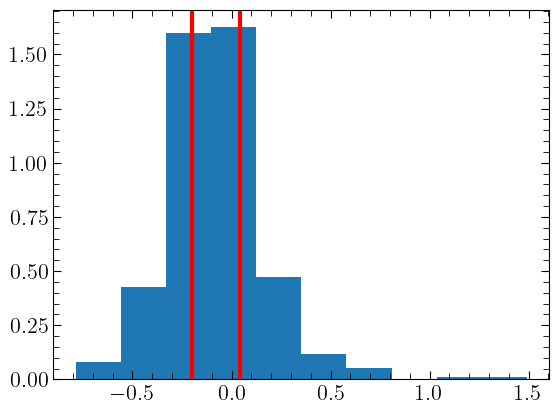

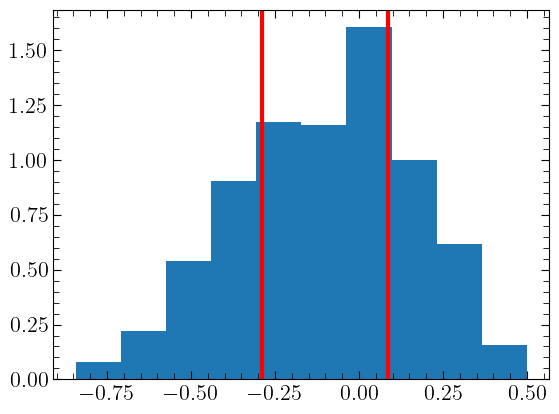

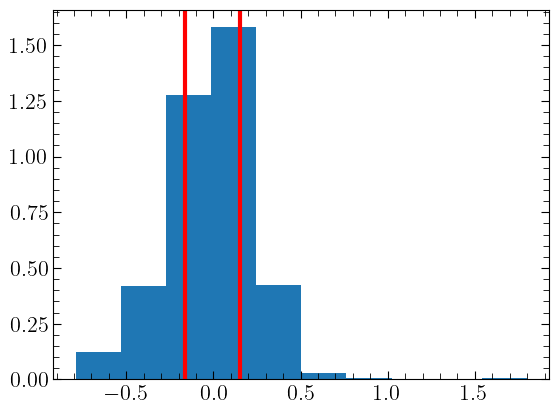

In [19]:
xy = fractional_deviation1

plt.hist(xy, density=True)
p25 = np.percentile(xy, 25)
p75 = np.percentile(xy, 75)
plt.axvline(p25, color='r')
plt.axvline(p75, color='r')
plt.show()

xy = fractional_deviation

plt.hist(xy, density=True)
p25 = np.percentile(xy, 25)
p75 = np.percentile(xy, 75)
plt.axvline(p25, color='r')
plt.axvline(p75, color='r')
plt.show()

xy = fractional_deviation_x1

plt.hist(xy, density=True)
p25 = np.percentile(xy, 25)
p75 = np.percentile(xy, 75)
plt.axvline(p25, color='r')
plt.axvline(p75, color='r')
plt.show()



# Spectral Index

In [ ]:
len(fractional_deviation), len(fractional_deviation1), len(fractional_deviation2), len(fractional_deviation_x1)

In [ ]:
len(nvss_flux)

In [ ]:
names = ['nvss', 'pybdsf']
search_radius = 20 * 3600 * u.arcsec
flux_thresh = 0.02 # Jy
# Set matching radius (e.g., 45 arcseconds for GLEAM-X resolution)
match_radius = beam_size * u.arcsec 
match_radius = 10 * u.arcsec # sqrt(40*22)

pybdsf_ra2, pybdsf_dec2, nvss_ra, nvss_dec, pybdsf_flux2, nvss_flux, pybdsf_flux2_err, nvss_flux_err = matched_sources(nvss_catalog, pybdsf_catalog, flux_thresh*1e-5,
                                                                                                                       target_ra_hms, target_dec_dms,
                                                                                                                       search_radius, match_radius, 
                                                                                                                       names)
fac_nvss = 1. 
nvss_flux *= (fac_nvss)
nvss_flux_err *= (fac_nvss)


In [ ]:
nu_nvss = 1.4e3 # MHz
nu_pybdsf = 147.4 # MHz

In [ ]:
pybdsf_ra2.shape, nvss_ra.shape

In [ ]:
alpha = ( np.log(nvss_flux) - np.log(pybdsf_flux2) ) / ( np.log(nu_nvss) - np.log(nu_pybdsf) ) 

In [ ]:
alpha.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data

# Compute statistics
alpha_mean = np.mean(alpha)
# alpha_16 = np.percentile(alpha, 16)
# alpha_84 = np.percentile(alpha, 84)
mcmc = np.percentile(alpha, [16, 50, 84])
q = np.diff(mcmc)
alpha_16, alpha_84 = q[:]



# Create figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(alpha, bins=20, color='C0', histtype='step', linestyle='-', linewidth=1.5,  label=r'\textrm{NVSS-GMRT}')

# Add vertical lines for statistics
ax.axvline(alpha_mean, color='C1', linestyle='--', linewidth=1.5)
ax.axvline(alpha_mean-alpha_16, color='C2', linestyle='--', linewidth=1.5)
ax.axvline(alpha_mean+alpha_84, color='C3', linestyle='--', linewidth=1.5)

# Get y-axis limits
y_max = plt.ylim()[1]

# Add text annotation with correct superscript & subscript formatting
# ax.text(0.5, y_max * 0.02, rf'$\alpha = {alpha_mean:.2f}^{{{alpha_16:.2f}}}_{{{alpha_84:.2f}}}$',
#         color='C1', ha='center', fontsize=12, transform=ax.transAxes)

ax.text(0.8, 0.8,  # Adjusted y-position
        rf'$\alpha = {alpha_mean:.2f}^{{+{alpha_84:.2f}}}_{{{-alpha_16:.2f}}}$',
        color='k', ha='center', fontsize=14, transform=ax.transAxes)

# Labels and legend
ax.set_xlabel(r'$\alpha$', fontsize=14)
ax.set_ylabel(r'$\rm{Count}$', fontsize=14)
ax.legend(fontsize='small')
# ax.grid(True, linestyle='--', alpha=0.5)

# Improve layout
plt.tight_layout()

# Save figure
plt.savefig('spectral_index.pdf', bbox_inches='tight', dpi=100)
plt.show()


In [ ]:
%